In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
import numpy as np

In [18]:
df = pd.read_pickle('../results/results.pkl')

In [19]:
def get_rows(
    args_dict,
):
    idx = {}
    for key, value in args_dict.items():
        if value is None:
            idx[key] = np.ones_like(df[key], dtype=bool)
        else:
            idx[key] = df[key] == value
        
    run_idx = np.ones_like(df['test_loss'], dtype=bool)
    for key, value in idx.items():
        run_idx = run_idx & value
    
    # print(f"Selected {run_idx.sum()} runs!")
    
    run_df = df[run_idx].reset_index(drop=True)   
    return run_df

In [20]:
def get_loss(
    args_dict,
):
    run_df = get_rows(args_dict)

    rank_set = np.unique(run_df['rank'])
    seed_set = np.unique(run_df['seed'])
    test_loss, test_loss_mean, test_loss_std = {}, {}, {}
    
    for method in ['sgd', 'ours']:
        test_loss_mean[method], test_loss_std[method], test_loss[method] = {}, {}, {}
        group_df = run_df[run_df['method'] == method].reset_index(drop=True)        
        for rank in rank_set:
            rank_df = group_df[group_df['rank'] == rank].reset_index(drop=True)
            test_loss[method][rank], test_loss_mean[method][rank], test_loss_std[method][rank] = {}, {}, {}
            for seed in seed_set:
                seed_df = rank_df[rank_df['seed'] == seed].reset_index(drop=True)        
                if method == 'sgd':
                    min_loss_index = seed_df['val_loss'].idxmin()
                    row_with_min_loss = seed_df.loc[min_loss_index]
                    test_loss[method][rank][seed] = row_with_min_loss['test_loss']

                elif method == 'ours':
                    test_loss[method][rank][seed] = seed_df['test_loss'].iloc[0]
                else:
                    raise notImplementError(f"We only support sgd and ours, not {method}!")
        
            test_loss_mean[method][rank] = pd.Series(test_loss[method][rank]).median()
            test_loss_std[method][rank] = pd.Series(test_loss[method][rank]).std()
    return pd.DataFrame(test_loss_mean), pd.DataFrame(test_loss_std)

# Randomly Initialized

In [21]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
target_depths = [1,2]
frozen_depth = 2
pretrained = 0

fnn_results = {}
for target_depth in target_depths:
    fnn_results[target_depth] = get_loss({
    'activation': activation,
    'use_bias': use_bias,
    'target_depth': target_depth,
    'frozen_depth': frozen_depth * target_depth,
    'init_mode': init_mode,
    'width': width,
    'exp': exp,
    'pretrained': pretrained,
    'tune_bias': 1,
    'rank_step': 0,
})[0]

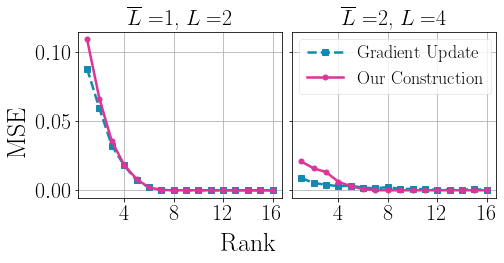

In [22]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    fnn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, linewidth = lw, markersize = sgd_ms)
    fnn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, linewidth = lw, markersize = our_ms)
    ax[i].set_title(r'$\overline{L} =$' + str(target_depth) + r', $L =$' + str(target_depth * 2), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)

# ax[0].set_ylim(0,0.15)
ax[1].legend(fontsize=18, bbox_to_anchor=(1.02,1.01))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/fnn_approx.pdf')
# Show the plot
plt.show()


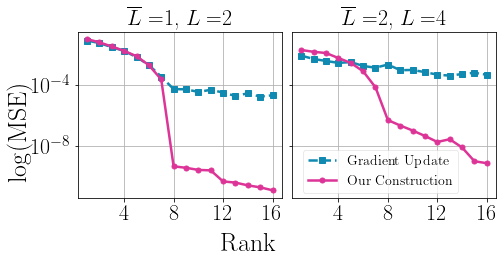

In [23]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

sgd_marker, sgd_color, sgd_lt, sgd_ms = 's', '#118AB2', '--', 6
our_marker, our_color, our_lt, our_ms = 'o', '#DD3497', '-', 5
lw = 2.5

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    fnn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, linewidth = lw, markersize = sgd_ms, logy = True)
    fnn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, linewidth = lw, markersize = our_ms, logy = True)
    ax[i].set_title(r'$\overline{L} =$' + str(target_depth) + r', $L =$' + str(target_depth * 2), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)

# ax[0].set_ylim(0,0.15)
ax[1].legend(fontsize=14, bbox_to_anchor=(0.85,.33))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel(r'$\log$(MSE)', fontsize = 26)
    
plt.savefig('../figures/log_fnn_approx.pdf')
# Show the plot
plt.show()


## TFN Approximation

In [24]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'tfn'
pretrained = 0

target_depths = [1,2]

tfn_results = {}
for target_depth in target_depths:
    tfn_results[target_depth] = get_loss({
    'activation': activation,
    'use_bias': use_bias,
    'target_depth': target_depth,
    'frozen_depth': target_depth,
    'init_mode': 'default',
    'width': width,
    'exp': exp,
    'pretrained': pretrained,
})[0]

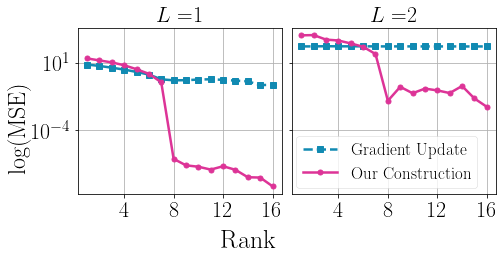

In [25]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend


fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    tfn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, logy = True, linewidth = lw, markersize = sgd_ms)
    tfn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, logy = True, linewidth = lw, markersize = our_ms)
    ax[i].set_title(r'$L=$'+str(target_depth), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)


# ax[0].set_ylim(0,0.15)
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('log(MSE)', fontsize = 24)
ax[1].legend(fontsize=17, bbox_to_anchor=(0.95,0.4))
    
plt.savefig('../figures/tfn_approx.pdf')
# Show the plot
plt.show()


# Pretrained Models

## FNN Approximation

In [26]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'fnn'
init_mode = 'default'
target_depths = [1,2]
pretrained = 1

fnn_results = {}
for target_depth in target_depths:
    fnn_results[target_depth] = get_loss({
    'activation': activation,
    'use_bias': use_bias,
    'target_depth': target_depth,
    'frozen_depth': frozen_depth * target_depth,
    'init_mode': init_mode,
    'width': width,
    'exp': exp,
    'pretrained': pretrained,
    'tune_bias': 1,
    'rank_step': 0,
})[0]

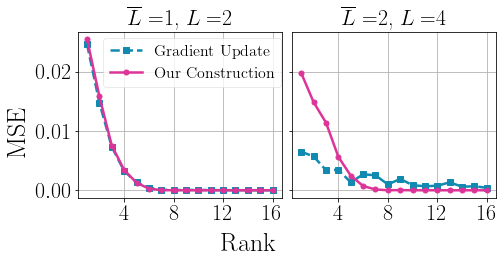

In [27]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    fnn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, linewidth = lw, markersize = sgd_ms)
    fnn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, linewidth = lw, markersize = our_ms)
    ax[i].set_title(r'$\overline{L} =$' + str(target_depth) + r', $L =$' + str(target_depth * 2), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)

# ax[0].set_ylim(0,0.15)
ax[0].legend(fontsize=16, bbox_to_anchor=(0.085,1.01))
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('MSE', fontsize = 26)
    
plt.savefig('../figures/fnn_approx_pretrained.pdf')
# Show the plot
plt.show()


## TFN Approximation

In [28]:
activation = 'relu'
use_bias = 1
width = 16
exp = 'tfn'
pretrained = 1

target_depths = [1,2]

tfn_results = {}
for target_depth in target_depths:
    tfn_results[target_depth] = get_loss({
        'activation': activation,
        'use_bias': use_bias,
        'target_depth': target_depth,
        'frozen_depth': target_depth,
        'init_mode': 'default',
        'width': width,
        'exp': exp,
        'pretrained': pretrained,
})[0]

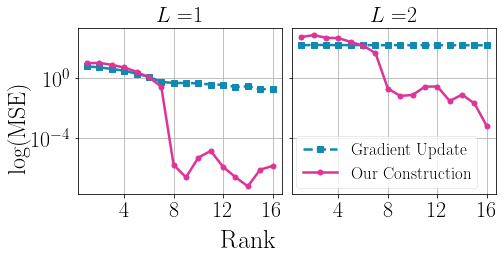

In [29]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    tfn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, logy = True, linewidth = lw, markersize = sgd_ms)
    tfn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, logy = True, linewidth = lw, markersize = our_ms)
    ax[i].set_title(r'$L=$'+str(target_depth), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)


# ax[0].set_ylim(0,0.15)
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('log(MSE)', fontsize = 24)
ax[1].legend(fontsize=17, bbox_to_anchor=(0.95,0.4))
    
plt.savefig('../figures/tfn_approx_pretrained_log.pdf')
# Show the plot
plt.show()


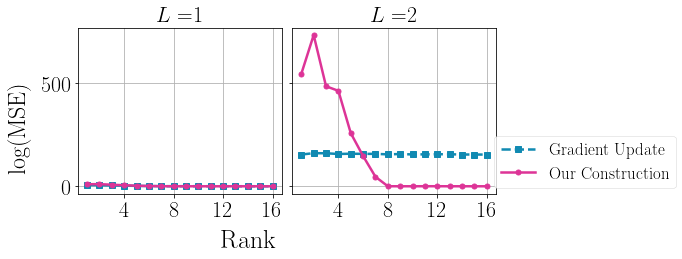

In [30]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.99, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(7, 3.5) #exact size of the figure

for i, target_depth in enumerate(target_depths):
    tfn_results[target_depth]['sgd'].plot(ax = ax[i], label = 'Gradient Update', color = sgd_color, marker = sgd_marker, linestyle = sgd_lt, logy = False, linewidth = lw, markersize = sgd_ms)
    tfn_results[target_depth]['ours'].plot(ax = ax[i], label = 'Our Construction', color = our_color, marker = our_marker, linestyle = our_lt, logy = False, linewidth = lw, markersize = our_ms)
    ax[i].set_title(r'$L=$'+str(target_depth), fontsize = 22)
    ax[i].set_xticks([4,8,12,16])
    ax[i].grid(True)


# ax[0].set_ylim(0,0.15)
fig.supxlabel('Rank', fontsize = 26)
fig.supylabel('log(MSE)', fontsize = 24)
ax[1].legend(fontsize=17, bbox_to_anchor=(0.95,0.4))
    
plt.savefig('../figures/tfn_approx_pretrained.pdf')
# Show the plot
plt.show()
